# Regresssion with outliers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

Load the read infer predict layer (ripl) and set venture's random seed to 1 to
ensure reproducibility.

In [3]:
%ripl --seed 42 --plugins plugins.py

Set seed of a new VentureScript RIPL to 42.00.
Loading plugin: plugins.py


## 1. Venture model component

In [4]:
%%venturescript
// MODEL
assume a = normal(0, 1) #continuous:0;
assume b = normal(0, 1) #continuous:1;
assume model_noise =  -log_logistic(log_odds_uniform() #continuous:2);
assume outlier_noise = 100;
assume outlier_probability = 0.01;

assume model = (x) -> { 
    if (bernoulli(outlier_probability) #discrete:x) {
        normal(0, outlier_noise)
    } else {
        normal(a * x + b, model_noise)
    }
};
// Next, generate synthetic data.
define true_a = 2.5;
define true_b = 3;

define N = 20;

define max_xs = 13;
define regular_xs = mapv((_) -> {uniform_continuous(1, max_xs)}, arange(N));
define regular_ys = mapv((x) -> {true_a * x + true_b}, regular_xs);

define outliers_xs = [4, 6 , 8, 10];
define outliers_ys = [30, -12, -15, 37];

define data_xs = append(outliers_xs, regular_xs);
define data_ys = append(outliers_ys, regular_ys);

## 3. Venture observation component

In [5]:
%%venturescript
// OBSERVATIONS
for_each(arange(size(data_xs)),
    (i) -> {
    observe model(${data_xs[i]}) = data_ys[i]
});


## 4. Venture infererence components

In [6]:
%%venturescript
// INFERENCE
define single_site_mh  = () -> {
    mh(default, one, 1)
};
define lbfgs_with_gibbs = () -> {
    gibbs(quote(discrete), one, 1);
    lbfgs_optimize(quote(continuous), all)
};
define loop_explicitly_over_random_choices = () -> {
    for_each(data_xs,
        (x) -> {
            gibbs(quote(discrete), x, 1)
    });
    mh(quote(continuous), 0, 1);
    mh(quote(continuous), 1, 1);
    mh(quote(continuous), 2, 1)
};
define hamiltonian_monte_carlo_with_gibbs = () -> {
    gibbs(quote(discrete), one, 1);
    hmc(quote(continuous), one, 0.1, 1, 1)
};

//SMC
define number_particles = 10;
// Define observer.
define observer = (x, y, label) -> {
    $label: observe model($x) = y;
};
// Simple, particle filter like SMC without rejuvenation.
define SMC_SIR = () -> {
    for_each(arange(size(data_xs)),
        (i) -> {
        observer(data_xs[i], data_ys[i], number_to_symbol(i));
        resample(number_particles)
    });
    for_each(arange(size(data_xs)),
        (i) -> {
        forget(number_to_symbol(i));
    });
};

// SMC with an HMC base rejuvenation step.
define SMC_HMC_rejuvenation = () -> {
    for_each(arange(size(data_xs)),
        (i) -> {
        observer(data_xs[i], data_ys[i], number_to_symbol(i));
        resample(number_particles);
        hmc(quote(continuous), one, 0.1, 1, 1)
    });
    for_each(arange(size(data_xs)),
        (i) -> {
        forget(number_to_symbol(i));
    })
};
// SMC with an gradient rejuvenation step.
define SMC_gradient_rejuvenation = () -> {
    for_each(arange(size(data_xs)),
        (i) -> {
        observer(data_xs[i], data_ys[i], number_to_symbol(i));
        resample(number_particles);
        grad_ascent(quote(continuous), all, 0.1, 1, 1)
    });
    for_each(arange(size(data_xs)),
        (i) -> {
        forget(number_to_symbol(i));
    })
};

In [7]:
data_xs = %venturescript data_xs
data_ys = %venturescript data_ys
regular_xs = %venturescript regular_xs
regular_ys = %venturescript regular_ys
outliers_xs = %venturescript outliers_xs
outliers_ys = %venturescript outliers_ys

## 5. Execute inference programs and plot results

In [8]:
def plot_trace(inf_prog, ax, steps):
    %venturescript reset_to_prior;
    for _ in range(steps):
        %venturescript {inf_prog}();
    a = %venturescript sample(a)
    b = %venturescript sample(b)
    all_x_values= np.linspace(1, 13, 100)
    all_f_values = a * all_x_values + b
    ax.plot(all_x_values, all_f_values, color='blue')
    return ax

In [9]:
def plot_n_traces(inf_prog, n, steps):
    fig, ax = plt.subplots()
    for _ in range(n):
        plot_trace(inf_prog, ax, steps)
    ax.scatter(outliers_xs, outliers_ys, label='Outlier data', color='red')    
    ax.scatter(regular_xs, regular_ys, label='Regular data', color='green')
    ax.plot([], [], color='blue', label='5 samples')
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.12),
        ncol=3,
        fontsize=8.
    )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim([0, 15])
    ax.set_ylim([-20, 40])
    fig.tight_layout()
    fig.set_size_inches(4, 3)
    #fig.savefig('results/linear-regression-with-outliers/pdf-files/%s.pdf' % (inf_prog,), bbox_inches='tight',)
    ax.set_title('%s: trace after %d steps'  % (inf_prog, steps,), y=1.11);
    #fig.savefig('results/linear-regression-with-outliers//%s.png' % (inf_prog,), bbox_inches='tight',)

# TODO
## a. decide how long inference should run for all of them.
## b. add explanantion about how to run SMC.

In [14]:
STEPS = 3
NUMBER_TRACES = 1

In [15]:
def run_inference(inf_prog):
     plot_n_traces(inf_prog, NUMBER_TRACES, STEPS)

In [16]:
inf_progs = [
    'SMC_HMC_rejuvenation',
    #'lbfgs_with_gibbs',
    #'loop_explicitly_over_random_choices',
    #'hamiltonian_monte_carlo_with_gibbs'
]

1 loop, best of 1: 1min 13s per loop


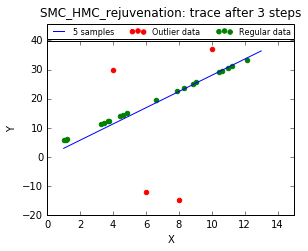

In [17]:
%%timeit -n1 -r1
for inf_prog in inf_progs:
    if 'SMC' in inf_progs:
        %venturescript resample(number_particles);
        %venturescript reset_to_prior;
    run_inference(inf_prog)